In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt

In [2]:
SOBEL_X = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype="int32")

SOBEL_Y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype="int32")

GAUSS = np.array(([1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]), dtype="float64")

BOX = np.array(([1, 1, 1], [1, 1, 1], [1, 1, 1]), dtype="int32")

In [3]:
def READ_IMG(path):
    img = cv2.imread(path)

    if img is None:
        raise ValueError('Invalid image...')
    else:
        plt.imshow(img)
        return img

#def normalize(img):
#    M = np.zeros(img.shape)
#    for i in range(img.shape[0]):
#        for j in range(img.shape[1]):
#            M[i,j] = ((img[i,j] - img.min())/(img.max() - img.min()))
#    return M

def convolve(img, kernel):
    
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height, img_width = img.shape[0], img.shape[1]
    pad_height, pad_width = kernel.shape[0] // 2, kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            RegOfInt = img[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (RegOfInt*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

def HARRIS_CORNER(_img, threshold):
    start = dt.now()
    
    img = cv2.cvtColor(_img,cv2.COLOR_BGR2GRAY)

    # Step-1: Spatial derivative calculation
    dx = convolve(img, SOBEL_X)
    dy = convolve(img, SOBEL_Y)

    row_no = img.shape[0]
    col_no = img.shape[1]
    M = np.zeros(img.shape)

    _dx2 = np.square(dx)
    _dy2 = np.square(dy)
    _dxy = dx*dy

    dx2 = convolve(_dx2, GAUSS)
    dy2 = convolve(_dy2, GAUSS)
    dxy = convolve(_dxy, GAUSS)

    k, wSize = 0.04, 5
    offset = int(wSize / 2)

    # Step-2 & 3: Structure tensor & Harris response calculation
    for y in range(offset, row_no-offset):
        for x in range(offset, col_no-offset):
            fx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
            fy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
            fxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])

            _A = np.array([[fx2,fxy],[fxy,fy2]])

            det = np.linalg.det(_A)
            tr = np.matrix.trace(_A)
            R = det - k*(tr**2)
            M[y-offset, x-offset] = R

    # Step-4: Apply threshold
    cv2.normalize(M, M, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, row_no-offset):
        for x in range(offset, col_no-offset):
            value = M[y, x]
            if value>threshold:
                cv2.circle(_img,(x,y),3,(0,150,255))

    end = dt.now()
    print('Required time to find corner: ', end - start)
    return _img

def PRINT_CORNER(img):
    plt.imshow(cv2.cvtColor(hc, cv2.COLOR_BGR2HSV))
    #plt.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
    plt.title("Harris Corner detector")
    plt.axis('off')

**Image 1**

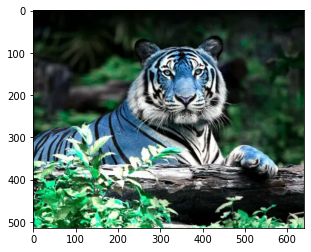

In [4]:
_img = READ_IMG("E:/Dataset/Tiger.jpg")

In [5]:
hc = HARRIS_CORNER(_img, 0.3) 

Required time to find corner:  0:00:27.483248


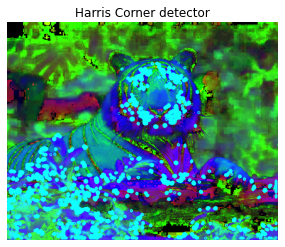

In [6]:
PRINT_CORNER(hc)

**Image 2**

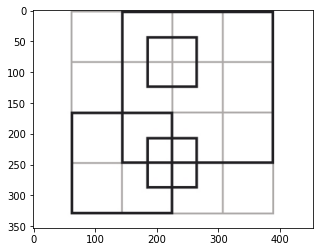

In [7]:
_img = READ_IMG("E:/Dataset/box.jpg")

In [8]:
hc = HARRIS_CORNER(_img, 0.16) 

Required time to find corner:  0:00:11.274562


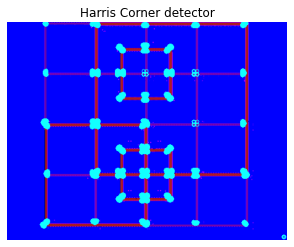

In [9]:
PRINT_CORNER(hc)